In [300]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import functions.color as c
import seaborn as sns
import joblib

palette = sns.color_palette("Dark2", n_colors=8)

In [282]:

# Load your data
df = pd.read_csv('cleaned_data/spy.csv', parse_dates=['Date'])

# Convert 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index for time series analysis
df.set_index('Date', inplace=True)

# Handle missing values (e.g., forward fill)
df.ffill(inplace=True)


In [283]:

# Create a moving average feature (5-day moving average of volume)
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

# Create lag features (e.g., previous day's volume)
df['Lag_Volume_1'] = df['Volume'].shift(1)

# Shift the target variable (volume) by one day to predict the next day's volume
df['Next_Day_Volume'] = df['Volume'].shift(-1)

# Drop rows with missing values after shifting (this will drop the last row because it has no 'Next_Day_Volume')
df.dropna(inplace=True)
df.head()


,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,Volume_MA5,Lag_Volume_1,Next_Day_Volume
Date,,,,,,,,,,,,,
1993-02-04,25.026437,25.096004,24.748173,25.043829,531500,4,3,5,2,1993,549180.0,529400.0,492100.0
1993-02-05,25.026436,25.078610,24.887303,25.026436,492100,5,4,5,2,1993,446960.0,531500.0,596100.0
1993-02-08,25.026436,25.113394,24.991653,25.026436,596100,8,0,6,2,1993,470080.0,492100.0,122100.0
1993-02-09,24.939478,24.939478,24.800345,24.852520,122100,9,1,6,2,1993,454240.0,596100.0,379600.0
1993-02-10,24.852521,24.904696,24.782955,24.887304,379600,10,2,6,2,1993,424280.0,122100.0,19500.0


In [ ]:

# Define the features (X) and target (y) for next-day prediction
X = df.drop(columns=['Volume', 'Next_Day_Volume'])  # Exclude actual volume and target
y = df['Next_Day_Volume']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=.1)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)


In [ ]:

# # Save the model to a file
# joblib.dump(xgb_model, 'model/volumemodel.pkl')


['model/volumemodel.pkl']

In [285]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'Mean Absolute Error (MAE): {mae:,.0f}')
print(f'Mean Squared Error (MSE): {mse:,.0f}')
print(f'Root Mean Squared Error (RMSE): {rmse:,.0f}')
print(f'R² Score: {r2:.4f}')
print(f'MAPE: {mape:.2f}%')

Mean Absolute Error (MAE): 17,559,146
Mean Squared Error (MSE): 1,152,829,258,007,322
Root Mean Squared Error (RMSE): 33,953,339
R² Score: 0.8729
MAPE: 97.17%


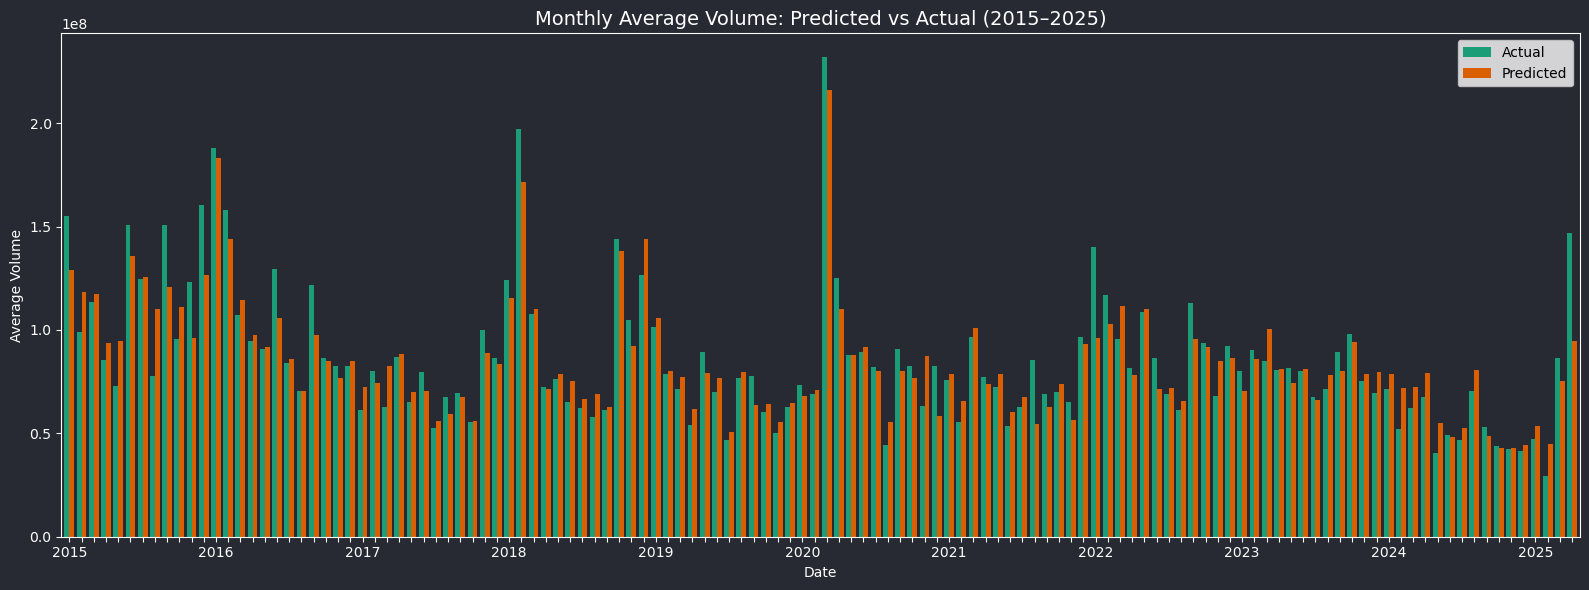

In [286]:
# Prepare results DataFrame
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)
results_df = results.copy()

# Filter to the last 10 years
results_10y = results_df[results_df.index.year >= 2015]

# Resample monthly
monthly_avg = results_10y.resample('ME').mean()

# Create figure and axis
fig, ax = plt.subplots(figsize=(16, 6))

# Now apply titles and labels
ax.set_title('Monthly Average Volume: Predicted vs Actual (2015–2025)', fontsize=14)
ax.set_xlabel('Year')
ax.set_ylabel('Average Volume')

# Set grid
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

c.customize_graph(ax)

monthly_avg.plot(kind='bar', ax=ax, width=0.8, color=[palette[0], palette[1]])
xticks = monthly_avg.index
tick_positions = list(range(len(xticks)))
tick_labels = [str(date.year) if date.month == 1 else '' for date in xticks]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0)

fig.tight_layout()
plt.show()



In [287]:
# 1. Filter 2025 data
df_2025 = df[df.index.year == 2025].copy()

# 2. Prepare features
X_2025 = df_2025.drop(columns=['Volume', 'Next_Day_Volume'], errors='ignore')

# 3. Predict
df_2025['Predicted'] = xgb_model.predict(X_2025)

# 4. Add Actual column
df_2025['Actual'] = df_2025['Volume']

# 5. Prepare results
results_2025 = df_2025.copy()
results_2025 = results_2025.sort_index()


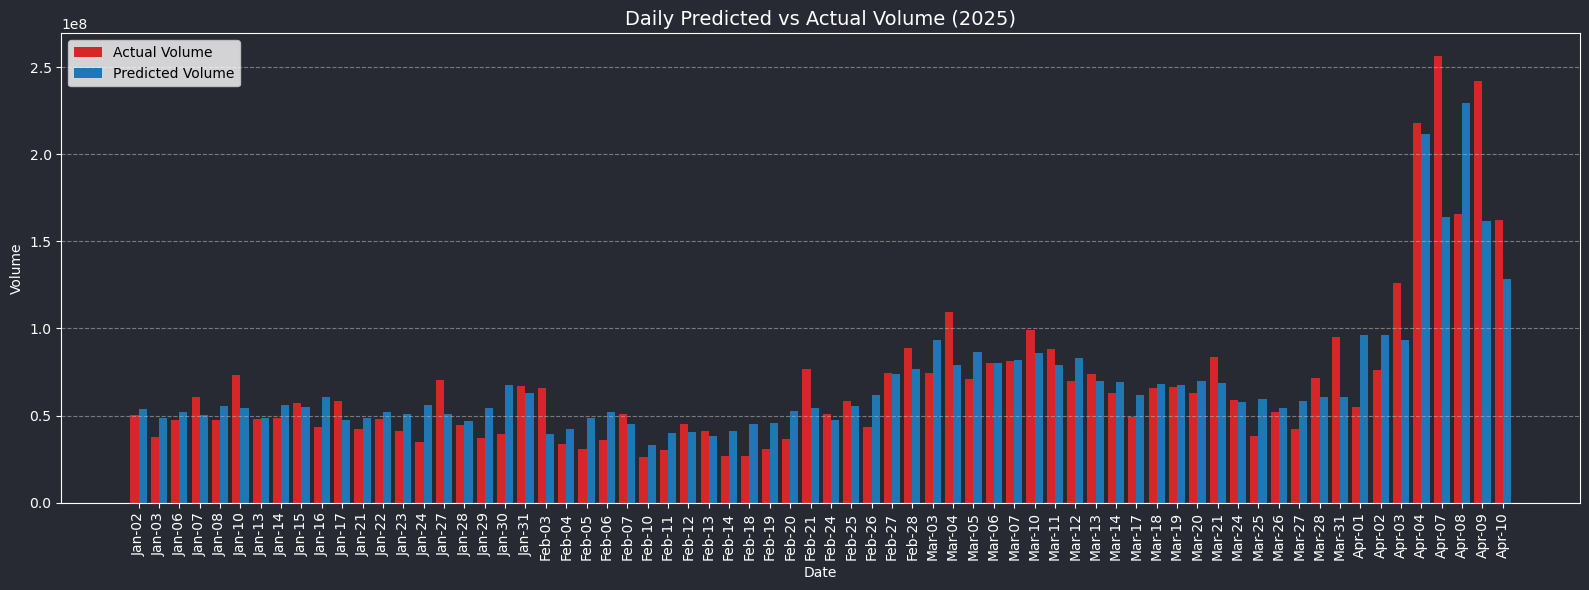

In [299]:

# 6. Plot using standardized structure
fig, ax = plt.subplots(figsize=(16, 6))

# Create positions for bars
x = range(len(results_2025))
bar_width = 0.4

# Format x-ticks (rotated daily labels)
tick_positions = [p + bar_width / 2 for p in x]
tick_labels = results_2025.index.strftime('%b-%d')
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=90)

# Titles and labels
ax.set_title('Daily Predicted vs Actual Volume (2025)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')

c.customize_graph(ax)

# Bar plots
ax.bar(x, results_2025['Actual'], width=bar_width, label='Actual Volume', color='tab:red', align='center')
ax.bar([p + bar_width for p in x], results_2025['Predicted'], width=bar_width, label='Predicted Volume', color='tab:blue', align='center')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

fig.tight_layout()
plt.show()



# Step 1: Load the dataset


In [ ]:

df = pd.read_csv('cleaned_data/spy.csv', parse_dates=['Date'])
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as the index
df.set_index('Date', inplace=True)


# Step 2: Feature Engineering

In [290]:

# 1. Daily Returns (percentage change in close price)
df['Daily_Return'] = df['Close'].pct_change()

# 2. Price Range (High - Low)
df['Price_Range'] = df['High'] - df['Low']

# 3. Close-to-Open Price Change
df['Close_to_Open_Change'] = df['Close'] - df['Open']

# 4. Average Price (mean of High, Low, Close)
df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

# 5. Lagged Features (Lagged Close, Lagged Volume, etc.)
df['Lagged_Close'] = df['Close'].shift(1)
df['Lagged_Volume'] = df['Volume'].shift(1)

# 6. Volume Relative to Moving Average (Volume MA5)
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA5']

# 7. Lagged Returns (previous day's return)
df['Lagged_Return'] = df['Daily_Return'].shift(1)

# 8. Historical Volatility (Rolling Std of Returns over 5 days)
df['Rolling_Volatility'] = df['Daily_Return'].rolling(window=5).std()

# 9. Time-Based Features: Day of the Week, Week of the Year, Month
df['Day_of_Week'] = df.index.dayofweek  # Monday=0, Sunday=6
df['Week_of_Year'] = df.index.isocalendar().week
df['Month'] = df.index.month

# 10. Close-to-High Ratio (relative position of the close to the high of the day)
df['Close_to_High_Ratio'] = (df['Close'] - df['High']) / (df['High'] - df['Low'])

# 11. Target Feature: Next Day Volatility (Rolling Std of Returns over 5 days)
df['Next_Day_Volatility'] = df['Daily_Return'].shift(-1).rolling(window=5).std()

# Drop rows with missing values (due to shifts)
df = df.dropna()


# Split the data into features (X) and target (y)

In [291]:

X = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Day_of_Week', 'Week_of_Year', 'Month',
        'Daily_Return', 'Price_Range', 'Close_to_Open_Change', 'Average_Price', 'Lagged_Close',
        'Lagged_Volume', 'Volume_Ratio', 'Lagged_Return', 'Rolling_Volatility', 'Close_to_High_Ratio']]
y = df['Next_Day_Volatility']

# Step 4: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Initialize the XGBoost model
v_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)

# Step 6: Train the model
v_model.fit(X_train, y_train)

# Step 7: Make predictions
y_pred = v_model.predict(X_test)


In [ ]:
# joblib.dump(v_model, 'model/volatilitymodel.pkl')

['model/volatilitymodel.pkl']

# Evaluate the model

In [292]:

# Step 8: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
epsilon = 1e-10  # Small value to avoid division by zero
mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:,.2f}')
print(f'Mean Squared Error (MSE): {mse:,.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:,.2f}')
print(f'R² Score: {r2:.4f}')
print(f'MAPE: {mape:.2f}%')


Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
R² Score: 0.7536
MAPE: 24.67%


# --- Residual Plot ---

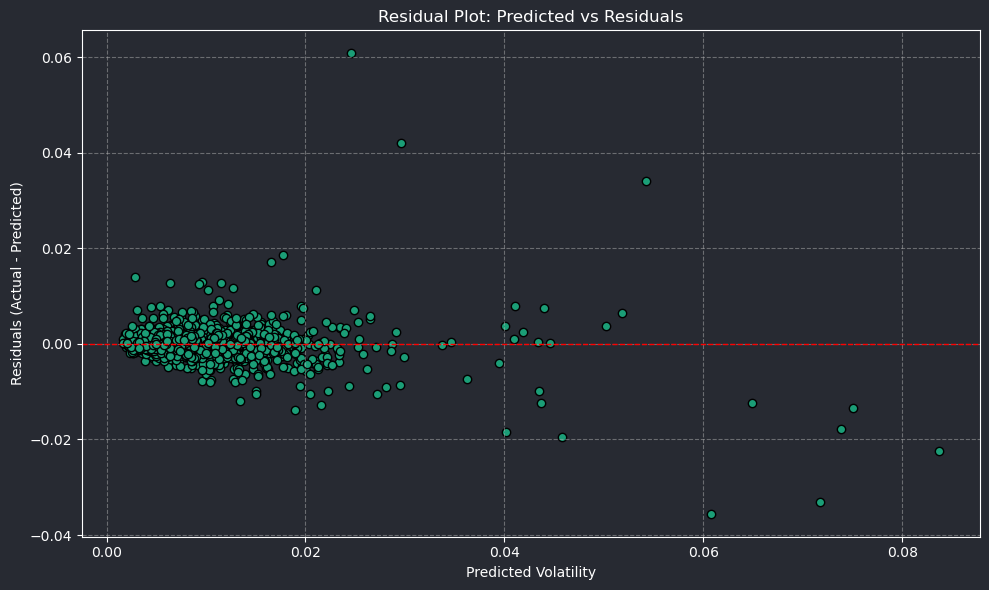

In [293]:

# Calculate residuals
residuals = y_test - y_pred

# Create the residual plot
plt.figure(figsize=(10, 6))
c.customize_graph(plt.gca())
plt.scatter(y_pred, residuals, color=palette[0], edgecolors='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot: Predicted vs Residuals')
plt.xlabel('Predicted Volatility')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# --- 4. Predict for 2025 ---

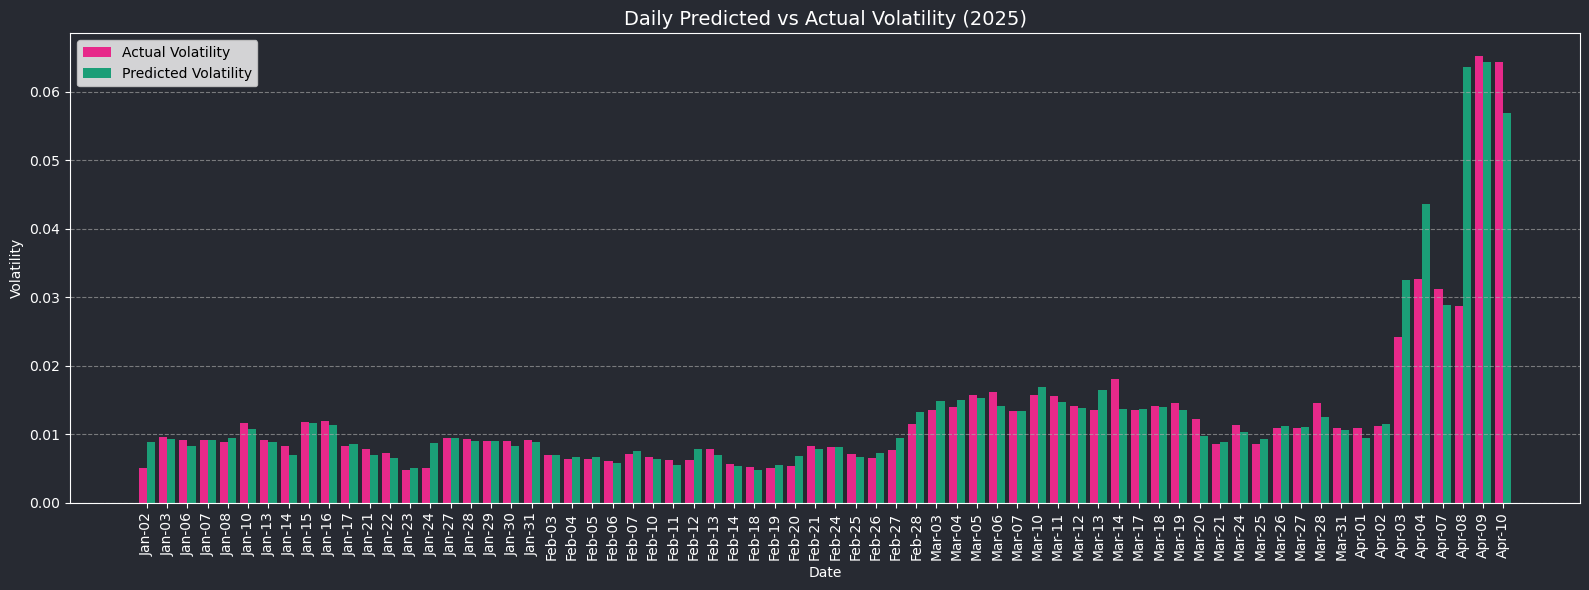

In [294]:

# Filter the DataFrame for the year 2025
df_2025 = df[df.index.year == 2025].copy()

# Make sure to use the same feature columns for prediction
X_2025 = df_2025[X.columns]
df_2025['Predicted_Volatility'] = v_model.predict(X_2025)

# --- 5. Plot the results ---
fig, ax = plt.subplots(figsize=(16, 6))

c.customize_graph(ax)

# Plot actual vs predicted volatility for 2025
x = range(len(df_2025))
bar_width = 0.4

ax.grid(True, axis='y', linestyle='--', alpha=0.6)
# Bar plots
ax.bar(x, df_2025['Rolling_Volatility'], width=bar_width, label='Actual Volatility',
       color=palette[3], align='center')
ax.bar([i + bar_width for i in x], df_2025['Predicted_Volatility'], width=bar_width,
       label='Predicted Volatility', color=palette[0], align='center')

# Tick labels: every date, rotated
tick_positions = [p + bar_width / 2 for p in x]
tick_labels = df_2025.index.strftime('%b-%d')
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=90)

# Titles and labels
ax.set_title('Daily Predicted vs Actual Volatility (2025)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.legend()


# Layout
fig.tight_layout()
plt.show()


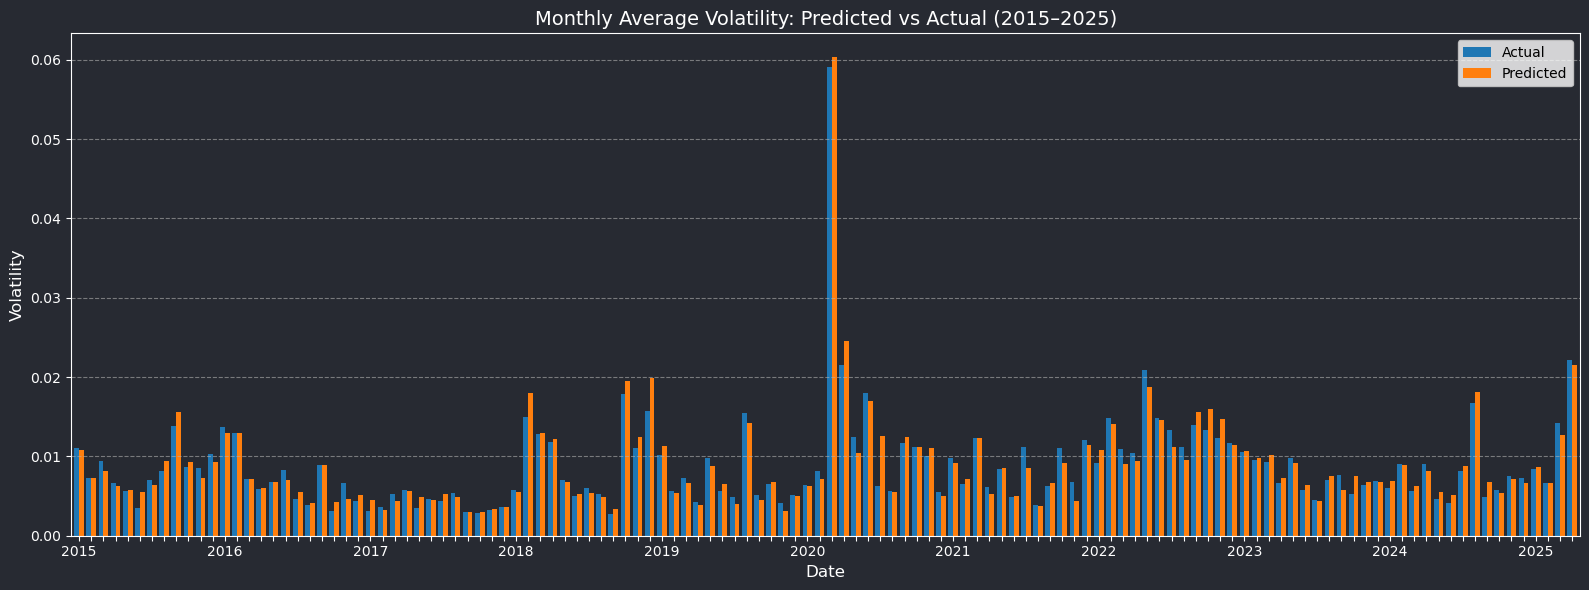

In [295]:
# Assuming you have results DataFrame with 'Actual' and 'Predicted' columns for volatility
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)

# Step 1: Filter the results for the last 10 years (2015 onwards)
results_10y = results[results.index.year >= 2015]

# Step 2: Resample monthly to get the average of the Actual and Predicted volatility values
monthly_avg = results_10y.resample('ME').mean()

# Step 3: Create figure and axis for the plot
fig, ax = plt.subplots(figsize=(16, 6))

# Step 6: Customize plot aesthetics
ax.set_title('Monthly Average Volatility: Predicted vs Actual (2015–2025)', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Volatility', fontsize=12)

c.customize_graph(ax)
monthly_avg.plot(kind='bar', ax=ax, width=0.8, color=['tab:blue', 'tab:orange'])
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

xticks = monthly_avg.index
tick_positions = list(range(len(xticks)))
tick_labels = [str(date.year) if date.month == 1 else '' for date in xticks]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0)
# Step 7: Layout adjustment and show plot
fig.tight_layout()
plt.show()
